In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
dir_path = r"C:/Users/KIIT/Desktop\pneumonia_detection\chest_xray"

In [3]:
''' training path '''
train_p = os.path.join(dir_path, "train")

''' test path '''
test_p =os.path.join(dir_path, "test")

''' val path '''
val_p = os.path.join(dir_path, "val")

In [4]:
''' PNEUMONIA images '''
p_train_images = glob.glob(train_p + "/PNEUMONIA/*.jpeg")

''' NORMAL  images '''
n_train_images = glob.glob(train_p + "/NORMAL/*.jpeg")

In [5]:
df = pd.DataFrame(np.concatenate([[0]*len(n_train_images) , [1] *  len(p_train_images)]),columns=["class"])
df

,class
0,0
1,0
2,0
3,0
4,0
...,...
5211,1
5212,1
5213,1
5214,1


In [6]:
#sns.countplot(df['class'],data=df)

In [7]:
''' Data Augmentation '''
train_ds = ImageDataGenerator(rescale =1/255, shear_range=10, zoom_range = 0.2, horizontal_flip = True, 
                              width_shift_range=0.2, fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
    rescale = 1/255
)

In [8]:
''' VGG16 Model '''

model1 = VGG16(include_top = False,weights='imagenet')

''' freezing layers '''
for i in model1.layers:
    i.trainable=False
    
out = model1.output

''' GlobalAveragePooling Layer '''
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(128, activation='relu')(out)

''' Classification Layer '''
pred = keras.layers.Dense(1, activation='sigmoid')(out)

''' final model '''
model= keras.Model(model1.input, pred)

lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' Compile the model '''
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr_schedule), metrics=['accuracy'])

In [9]:
''' lets see how model looks like '''
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [10]:
''' flow from directory '''
train_ds = train_ds.flow_from_directory(train_p, target_size=(150,150), batch_size= 16, class_mode='binary')

val_ds = val_datagen.flow_from_directory(val_p, target_size=(150,150),batch_size=8, class_mode='binary')

test_ds = val_datagen.flow_from_directory(test_p, target_size=(150,150), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
''' training '''
history = model.fit(train_ds, steps_per_epoch = 100, epochs=20, validation_data=val_ds)

Epoch 1/20
100/100 [==============================] - 145s 1s/step - loss: 2.0825 - accuracy: 0.7544 - val_loss: 0.5259 - val_accuracy: 0.7500
Epoch 2/20
100/100 [==============================] - 142s 1s/step - loss: 0.5218 - accuracy: 0.8031 - val_loss: 0.4829 - val_accuracy: 0.8125
Epoch 3/20
100/100 [==============================] - 151s 2s/step - loss: 0.3919 - accuracy: 0.8506 - val_loss: 0.4718 - val_accuracy: 0.8125
Epoch 4/20
100/100 [==============================] - 145s 1s/step - loss: 0.3151 - accuracy: 0.8656 - val_loss: 0.9472 - val_accuracy: 0.6875
Epoch 5/20
100/100 [==============================] - 160s 2s/step - loss: 0.3168 - accuracy: 0.8919 - val_loss: 0.2672 - val_accuracy: 0.8750
Epoch 6/20
100/100 [==============================] - 183s 2s/step - loss: 0.3176 - accuracy: 0.8850 - val_loss: 0.3860 - val_accuracy: 0.8125
Epoch 7/20
100/100 [==============================] - 190s 2s/step - loss: 0.2997 - accuracy: 0.8731 - val_loss: 1.6177 - val_accuracy: 0.6875

In [13]:
''' evaluating model '''
accuracy = model.evaluate(test_ds)[1]

20/20 [==============================] - 64s 3s/step - loss: 0.3321 - accuracy: 0.9022


In [14]:
accuracy

0.9022436141967773

In [15]:
''' unfreezing layers '''
for layer in model1.layers:
    layer.trainable = True

In [16]:
'''Finetuning the model'''
lr = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' compile the model '''
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_schedule), loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [17]:
''' training '''
test_generator = model.fit(train_ds, steps_per_epoch = 200, epochs=5, validation_data=val_ds)

Epoch 1/5
200/200 [==============================] - 1129s 6s/step - loss: 0.2577 - binary_accuracy: 0.9156 - val_loss: 0.5259 - val_binary_accuracy: 0.7500
Epoch 2/5
200/200 [==============================] - 1226s 6s/step - loss: 0.1844 - binary_accuracy: 0.9359 - val_loss: 0.5114 - val_binary_accuracy: 0.6875
Epoch 3/5
200/200 [==============================] - 1248s 6s/step - loss: 0.1592 - binary_accuracy: 0.9478 - val_loss: 0.3236 - val_binary_accuracy: 0.8125
Epoch 4/5
200/200 [==============================] - 1323s 7s/step - loss: 0.1386 - binary_accuracy: 0.9559 - val_loss: 0.2545 - val_binary_accuracy: 0.9375
Epoch 5/5
200/200 [==============================] - 1321s 7s/step - loss: 0.1347 - binary_accuracy: 0.9538 - val_loss: 0.3592 - val_binary_accuracy: 0.8750


In [18]:
''' evaluating model '''
final_acc = model.evaluate(test_ds)[1]

20/20 [==============================] - 46s 2s/step - loss: 0.3084 - binary_accuracy: 0.9247


In [20]:
final_acc*100

92.46794581413269

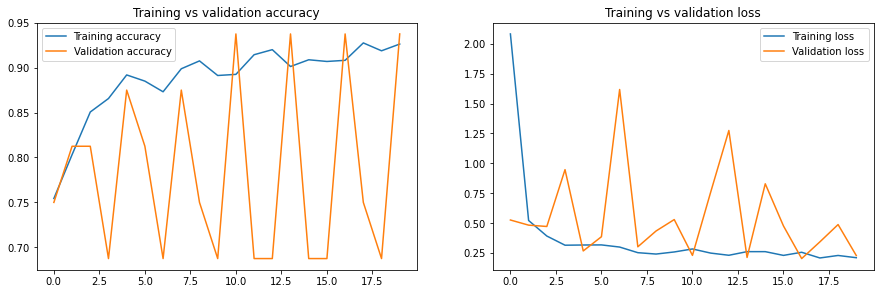

In [21]:
''' Training Accuracy and Validaion Accuracy graph '''
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

''' Training Loss and Validation Loss graph '''
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()